In [ ]:
# Project F1
# Run all cells at once if possible because variable x gets renamed several times so won't work if cells are run out of order

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.integrate import quad

In [39]:
def get_list(xdata, nevent, index):
    # split full data into list for one variable
    list = []
    for i in range(0, int(nevent)):
        list.append(xdata[i][index])
    
    return list

In [40]:
def make_subplot(i, j, xlabel, data, bins, colour):
    # return ax object to plot on subplot grid
    ax = plt.subplot2grid((2,3), (i,j), rowspan=1, colspan=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    hist, bins, p = ax.hist(data, bins=bins, color=colour)
    
    return ax, hist, bins

In [41]:
def get_max(hist, bins):
    # simple pleak finder for bin entry with most entries
    imax = np.where(hist == max(hist))[0][0]
    m = bins[imax]
    
    return m

In [42]:
def sideband_sub(mass_series, m, sig_width, sep):
    # sideband subtraction return number of signal events in region
    lower_bound = m - 0.5 * sig_width
    upper_bound = m + 0.5 * sig_width
    sig_region = mass_series[(mass_series > lower_bound) & (mass_series < upper_bound)]
    region_events = sig_region.size
    
    sideband_width = 0.5 * sig_width
    bg_lower_bound1 = m - sep - sideband_width
    bg_upper_bound1 = m - sep
    bg_lower_bound2 = m + sep
    bg_upper_bound2 = m + sep + sideband_width
    bg_events1 = mass_series[(mass_series > bg_lower_bound1) & (mass_series < bg_upper_bound1)]
    bg_events2 = mass_series[(mass_series > bg_lower_bound2) & (mass_series < bg_upper_bound2)]
    bg_events = bg_events1.size + bg_events2.size
    
    sig_events = region_events - bg_events
    
    return sig_events

In [104]:
# import data
f = open("ups-15-small.bin", "r")
datalist = np.fromfile(f, dtype=np.float32)

# number of events
nevent = len(datalist) / 6
xdata = np.split(datalist, nevent)
print(xdata[0])

# make list of invariant mass of events
mass_list = get_list(xdata, nevent, 0)
tp_pair_list = get_list(xdata, nevent, 1)
rap_list = get_list(xdata, nevent, 2)
p_pair_list = get_list(xdata, nevent, 3)
tp1_list = get_list(xdata, nevent, 4)
tp2_list = get_list(xdata, nevent, 5)

[  9.473305    5.279369    4.054099  152.1793      3.7385848   7.0808444]


In [108]:
# pandas dataframe
df = pd.DataFrame({
    'mass': mass_list,
    'tp pair': tp_pair_list,
    'rap': rap_list,
    'p pair': p_pair_list,
    'tp1': tp1_list,
    'tp2': tp2_list,
})

# clean outliers with z-score
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [109]:
# column headers
df.head()

,mass,tp pair,rap,p pair,tp1,tp2
0,9.473305,5.279369,4.054099,152.179306,3.738585,7.080844
1,9.812292,7.250655,3.913863,181.672607,2.996603,4.724026
2,9.564719,4.831397,3.033560,50.292870,7.580468,2.939981
3,10.440112,6.845929,3.971565,181.712784,3.264303,6.338173
4,10.752894,1.928041,5.350344,203.105118,4.387239,6.128740


In [110]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927224 entries, 0 to 936698
Data columns (total 6 columns):
mass       927224 non-null float64
tp pair    927224 non-null float64
rap        927224 non-null float64
p pair     927224 non-null float64
tp1        927224 non-null float64
tp2        927224 non-null float64
dtypes: float64(6)
memory usage: 49.5 MB


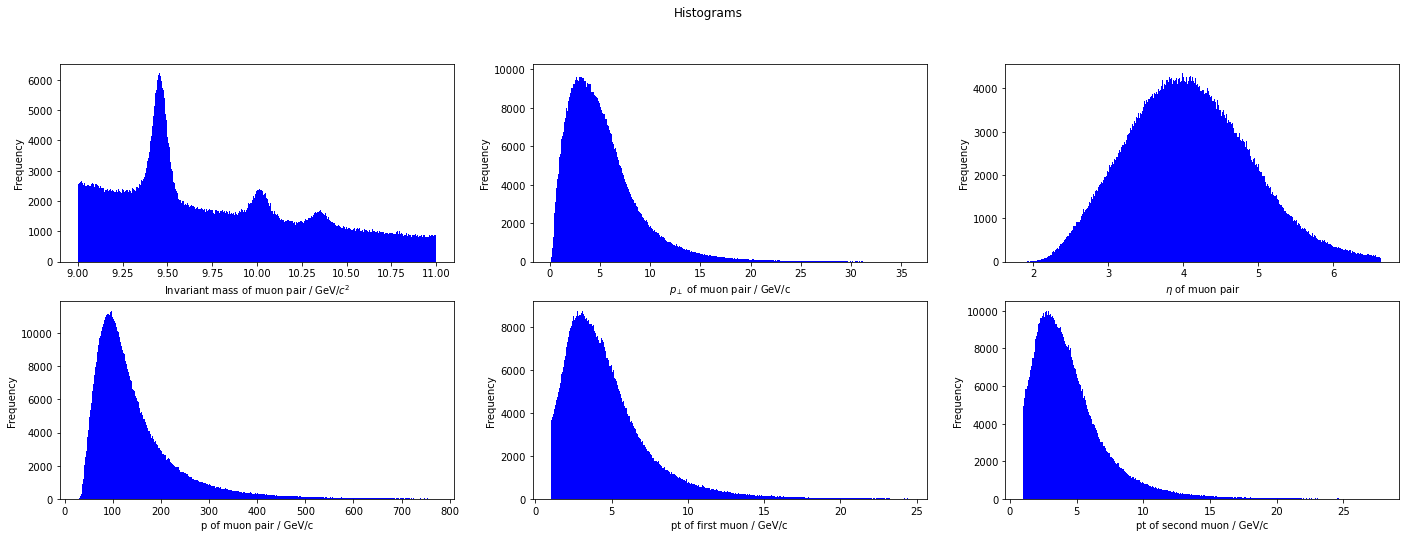

In [47]:
# plot histograms of six variables
plt.figure(figsize=(24, 8))
bins = 500

ax1, hist1, bins1 = make_subplot(0, 0, 'Invariant mass of muon pair / GeV/$c^2$', df['mass'], bins, 'blue')
ax2, hist2, bins2 = make_subplot(0, 1, '$p_{\perp}$ of muon pair / GeV/c', df['tp pair'], bins, 'blue')
ax3, hist3, bins3 = make_subplot(0, 2, '$\eta$ of muon pair', df['rap'], bins, 'blue')
ax4, hist4, bins4 = make_subplot(1, 0, 'p of muon pair / GeV/c', df['p pair'], bins, 'blue')
ax5, hist5, bins5 = make_subplot(1, 1, 'pt of first muon / GeV/c', df['tp1'], bins, 'blue')
ax6, hist6, bins6 = make_subplot(1, 2, 'pt of second muon / GeV/c', df['tp2'], bins, 'blue')

plt.suptitle('Histograms')
plt.show()

In [111]:
# split mass spectrum into peak regions by eye
i1 = np.where(bins1 < 9.3)[0][-1]
i2 = np.where(bins1 < 9.62)[0][-1]
i3 = np.where(bins1 < 9.8)[0][-1]
i4 = np.where(bins1 < 10.12)[0][-1]
i5 = np.where(bins1 < 10.25)[0][-1]
i6 = np.where(bins1 < 10.5)[0][-1]

mbins_arrays = np.split(bins1, np.array([i1, i2, i3, i4, i5, i6]))
mhist_arrays = np.split(hist1, np.array([i1, i2, i3, i4, i5, i6]))

mbins1 = mbins_arrays[1]
mbins2 = mbins_arrays[3] 
mbins3 = mbins_arrays[5]

mhist1 = mhist_arrays[1]
mhist2 = mhist_arrays[3] 
mhist3 = mhist_arrays[5]

In [112]:
# find peak positions with simple function
m1 = get_max(mhist1, mbins1)
m2 = get_max(mhist2, mbins2)
m3 = get_max(mhist3, mbins3)

print(m1)
print(m2)
print(m3)

m_diff2 = m2 - m1
m_diff3 = m3 - m1

9.451998582839966
10.011995645523072
10.3519938621521


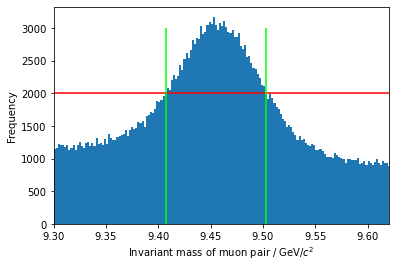

FWHM1 = 0.096, by visual inspection.
Resolution = 0.041, assuming gaussian form.


In [113]:
# estimate FWHM by visual inspection of histogram to help guess paramters in fitting later
hist_temp, bins_temp, p = plt.hist(df['mass'], bins=1000)

plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('Frequency')
plt.xlim(9.3, 9.62)
plt.hlines(2000, 9.3, 9.62, colors='red')
plt.vlines([9.407, 9.503], 0, 3000, colors='lime')
plt.show()

FWHM1 = 9.503 - 9.407
res1 = FWHM1 / 2.355
print('FWHM1 = ' + str(round(FWHM1, 3)) + ', by visual inspection.')
print('Resolution = ' + str(round(res1, 3)) + ', assuming gaussian form.')

In [114]:
# estimate nuber of signal events in region to help guess paramters in fitting later
mass_series = df['mass']
sig_width = 300 / 1000
sep = 0.4

sig_events1 = sideband_sub(mass_series, m1, sig_width, sep)

In [117]:
# functions for fitting single peaks
def comp_func2(x, sigma, mu, lam, a):
    # function not used but is option to do normalisation of exp by numerical integration
    #print(str(sigma) + ' ' + str(mu) + ' ' + str(lam) + ' ' + str(a))
    gaussian = np.exp(-0.5*((x-mu)/sigma)**2)
    exponential = np.exp(-1*lam*x)
    N = quad(comp_func, np.amin(x), np.amax(x), args=(sigma, mu, lam, a))[0]
    func = (1/N) * (a * gaussian + (1 - a) * exponential)
    return func

In [118]:
def comp_func3(x, sigma, mu, lam, a):
    # function to return normalised over x composite PDF
    gaussian = (1/(sigma*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu)/sigma)**2)
    exponential = (-lam / (np.exp(-1*lam*np.amax(x)) - np.exp(-1*lam*np.amin(x)))) * np.exp(-1*lam*x)
    func = a * gaussian + (1 - a) * exponential
    return func

In [119]:
def get_NLL(params):
    # return negative log likelihood for sample data x
    sigma, mu, lam, a = params[0], params[1], params[2], params[3]
    p_given_params = comp_func3(x, sigma, mu, lam, a)
    #p_given_params = (1/(sigma*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu)/sigma)**2)

    NLL = -np.sum(np.log(p_given_params))
    
    return NLL

In [ ]:
m1_series = mass_series[(mass_series > 9.30) & (mass_series < 9.60)]
x = np.array(m1_series)

In [127]:
# fit for first peak region
guess = np.array([0.03991755, 9.45703085, 0.81777866, 0.37400712])
results = minimize(get_NLL, guess, method='BFGS', options={'disp': True})
results
# hess_inv diagonals give square of parameter errors

         Current function value: -335819.236838
         Iterations: 29
         Function evaluations: 319
         Gradient evaluations: 53


      fun: -335819.23683828407
 hess_inv: array([[ 2.75851830e-08, -1.04806409e-08, -4.51351904e-08,
         2.57043090e-08],
       [-1.04806409e-08,  6.25066090e-08,  1.05539526e-07,
        -1.39728094e-08],
       [-4.51351904e-08,  1.05539526e-07,  6.18268758e-07,
        -2.03879066e-07],
       [ 2.57043090e-08, -1.39728094e-08, -2.03879066e-07,
         5.69214657e-07]])
      jac: array([0.00390625, 0.01171875, 0.00390625, 0.0078125 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 319
      nit: 29
     njev: 53
   status: 2
  success: False
        x: array([0.03991744, 9.45703094, 0.81780971, 0.37400749])

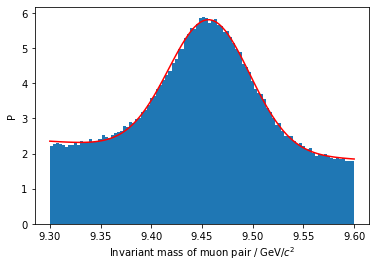

In [128]:
# plot best-estimate PDF on top of normalised histogram
hist, bins, p = plt.hist(x, bins=100, density=True)
sigmaf = results.x[0]
muf = results.x[1]
lamf = results.x[2]
af = results.x[3]
x_min = np.amin(x)
x_max = np.amax(x)
x_trial = np.linspace(x_min, x_max, 100)
y = comp_func3(x_trial, sigmaf, muf, lamf, af)
plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('P')
plt.plot(x_trial, y, c='r')

In [80]:
# same process for second peak
m1_series = mass_series[(mass_series > 9.8) & (mass_series < 10.2)]
x = np.array(m1_series)
guess = np.array([0.04533419, 10.01894799, 0.56787207, 0.14685767])
results = minimize(get_NLL, guess, method='BFGS', options={'disp': True})
results

         Current function value: -161989.754630
         Iterations: 13
         Function evaluations: 798
         Gradient evaluations: 131


      fun: -161989.754629627
 hess_inv: array([[ 2.62163512e-07,  5.64422492e-08, -1.99160007e-07,
        -2.62163490e-07],
       [ 5.64422492e-08,  3.50436651e-07,  2.23485470e-07,
        -5.64422492e-08],
       [-1.99160007e-07,  2.23485470e-07,  1.37751823e-05,
         1.99160007e-07],
       [-2.62163490e-07, -5.64422492e-08,  1.99160007e-07,
         2.62163547e-07]])
      jac: array([-0.00195312, -0.01171875,  0.        ,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 798
      nit: 13
     njev: 131
   status: 2
  success: False
        x: array([ 0.04533234, 10.01894705,  0.56787489,  0.14685202])

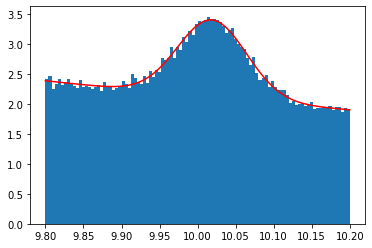

In [81]:
# plot of second peak
hist, bins, p = plt.hist(x, bins=100, density=True)
sigmaf = results.x[0]
muf = results.x[1]
lamf = results.x[2]
af = results.x[3]
x_min = np.amin(x)
x_max = np.amax(x)
x_trial = np.linspace(x_min, x_max, 100)
y = comp_func3(x_trial, sigmaf, muf, lamf, af)
plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('P')
plt.plot(x_trial, y, c='r')

In [86]:
# third peak
m1_series = mass_series[(mass_series > 10.2) & (mass_series < 10.5)]
x = np.array(m1_series)
guess = np.array([0.04200804, 10.35027951, 0.53192649, 0.11352147])
results = minimize(get_NLL, guess, method='BFGS', options={'disp': True})
results

         Current function value: -124862.383533
         Iterations: 9
         Function evaluations: 576
         Gradient evaluations: 94


      fun: -124862.38353334299
 hess_inv: array([[ 2.54225360e-06, -9.91894406e-07, -8.39474320e-07,
         1.23314199e-05],
       [-9.91894406e-07,  1.66988824e-06, -1.08889548e-06,
        -5.91460082e-06],
       [-8.39474320e-07, -1.08889548e-06,  9.35361889e-06,
        -2.45700228e-06],
       [ 1.23314199e-05, -5.91460082e-06, -2.45700228e-06,
         8.10201021e-05]])
      jac: array([ 0.        , -0.00097656, -0.00097656,  0.00683594])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 576
      nit: 9
     njev: 94
   status: 2
  success: False
        x: array([ 0.04200767, 10.35028075,  0.53192849,  0.11352579])

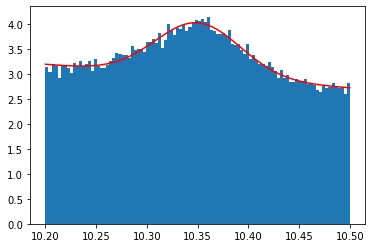

In [88]:
# third peak
hist, bins, p = plt.hist(x, bins=100, density=True)
sigmaf = results.x[0]
muf = results.x[1]
lamf = results.x[2]
af = results.x[3]
x_min = np.amin(x)
x_max = np.amax(x)
x_trial = np.linspace(x_min, x_max, 100)
y = comp_func3(x_trial, sigmaf, muf, lamf, af)
plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('P')
plt.plot(x_trial, y, c='r')

In [63]:
# new fitting functions for combined PDF of three peaks
def comp_func_full(x, sigma1, mu1, sigma2, mu2, sigma3, mu3, lam, a1, a2, a3):
    # return full PDF
    gaussian1 = (1/(sigma1*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu1)/sigma1)**2)
    gaussian2 = (1/(sigma2*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu2)/sigma2)**2)
    gaussian3 = (1/(sigma3*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu3)/sigma3)**2)
    exponential = (-lam / (np.exp(-1*lam*np.amax(x)) - np.exp(-1*lam*np.amin(x)))) * np.exp(-1*lam*x)
    func = a1 * gaussian1 + a2 * gaussian2 + a3 * gaussian3 + (1 - a1 - a2 - a3) * exponential
    return func

In [64]:
def get_NLL_full(params):
    # return NLL of full sample data for PDF
    sigma1, mu1, sigma2, mu2, sigma3, mu3, lam, a1, a2, a3 = params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9]
    p_given_params = comp_func_full(x, sigma1, mu1, sigma2, mu2, sigma3, mu3, lam, a1, a2, a3)
    #p_given_params = (1/(sigma*(2*np.pi)**0.5)) * np.exp(-0.5*((x-mu)/sigma)**2)

    NLL = -np.sum(np.log(p_given_params))
    
    return NLL

In [132]:
# reset x to full mass sample data
x = mass_series
guess_full = np.array([0.04301244, 9.45606244, 0.04595414, 10.01920664, 0.04663136, 10.35097689, 0.59272158, 0.11544125, 0.0279732, 0.01413018])
results_full = minimize(get_NLL_full, guess_full, method='Nelder-Mead', options={'disp': True})
results_full

Optimization terminated successfully.
         Current function value: 530312.445613
         Iterations: 188
         Function evaluations: 310


 final_simplex: (array([[ 0.04301094,  9.45606411,  0.04595628, 10.01921073,  0.04663122,
        10.35097279,  0.59273821,  0.11544255,  0.02797617,  0.01413248],
       [ 0.04301186,  9.45606293,  0.04595327, 10.01921031,  0.04662453,
        10.35097683,  0.5927384 ,  0.11544155,  0.02797531,  0.01413208],
       [ 0.04301192,  9.456063  ,  0.0459543 , 10.01920557,  0.04662385,
        10.3509802 ,  0.59273433,  0.11544373,  0.02797635,  0.01412886],
       [ 0.04301131,  9.4560636 ,  0.04595753, 10.01920886,  0.04663418,
        10.35098086,  0.59273929,  0.11544108,  0.02797764,  0.0141343 ],
       [ 0.04301244,  9.45606244,  0.04595414, 10.01920664,  0.04663136,
        10.35097689,  0.59272158,  0.11544125,  0.0279732 ,  0.01413018],
       [ 0.04301113,  9.45606321,  0.04595587, 10.01921332,  0.04663118,
        10.35098189,  0.59275331,  0.1154412 ,  0.02797645,  0.01413241],
       [ 0.04301145,  9.45606187,  0.04595766, 10.01920913,  0.04663795,
        10.3509713 ,  0.5927

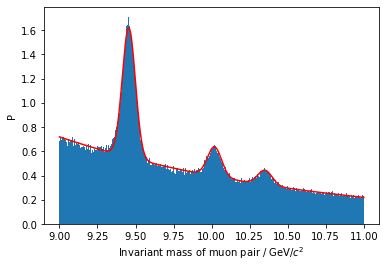

In [133]:
# results gave bes-estimates of parameters
hist, bins, p = plt.hist(x, bins=1000, density=True)

sigma1f = results_full.x[0]
mu1f = results_full.x[1]

sigma2f = results_full.x[2]
mu2f = results_full.x[3]

sigma3f = results_full.x[4]
mu3f = results_full.x[5]

lamf = results_full.x[6]

a1f = results_full.x[7]
a2f = results_full.x[8]
a3f = results_full.x[9]

x_min = np.amin(x)
x_max = np.amax(x)
x_trial = np.linspace(x_min, x_max, 1000)
y = comp_func_full(x_trial, sigma1f, mu1f, sigma2f, mu2f, sigma3f, mu3f, lamf, a1f, a2f, a3f)
plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('P')
plt.plot(x_trial, y, c='r')

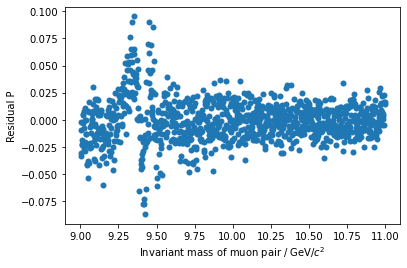

In [144]:
# plot residuals after determining bin centres
bins_width = bins[1] - bins[0]
res_x_trial = (bins + 0.5 * bins_width)[:-1]
res_y = hist - comp_func_full(res_x_trial, sigma1f, mu1f, sigma2f, mu2f, sigma3f, mu3f, lamf, a1f, a2f, a3f)
plt.xlabel('Invariant mass of muon pair / GeV/$c^2$')
plt.ylabel('Residual P')
plt.scatter(res_x_trial, res_y, linewidths=0.01)